In [2]:
import sys
import warnings
import umap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm

sys.path.append("../")
from utils import load_data, StrokeParams, FetalHealthParams

warnings.filterwarnings("ignore")

RANDOM_STATE = 666

# param_grid = {
#     "n_neighbors": [5, 15, 30, 50],
#     "min_dist": [0.0, 0.1, 0.5, 0.99],
#     "metric": ["euclidean", "manhattan", "cosine"],
# }

param_grid = {
    "n_neighbors": [5, 50],  # Reduced range to two values
    "min_dist": [0.0, 0.99],  # Reduced range to two values
    "metric": [
        "euclidean"
    ],  # Considered the most impactful based on domain knowledge or preliminary tests
}


def gridsearch_umap(X, y, param_grid, n_splits=5, random_state=None):
    """
    Custom grid search for optimizing UMAP hyperparameters with cross-validation, using silhouette scores.

    Parameters:
    - X: Input data.
    - y: Ground truth labels.
    - param_grid: Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values.
    - n_splits: Number of folds for cross-validation.
    - random_state: Seed used by the random number generator.

    Returns:
    - best_score: The highest silhouette score achieved.
    - best_params: The parameters that yielded the best_score.
    """
    best_score = -np.inf
    best_params = None

    # Create parameter grid
    grid = ParameterGrid(param_grid)

    for params in tqdm(grid, leave=False):
        cv_scores = []

        # Cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Initialize and fit UMAP with current set of parameters
            reducer = umap.UMAP(
                random_state=random_state, **params  # Unpack parameters into UMAP
            )
            X_train_reduced = reducer.fit_transform(X_train, y_train)

            # Calculate silhouette score using ground truth labels
            score = silhouette_score(
                X_train_reduced, y_train
            )  # Use y_train as true labels

            cv_scores.append(score)

        # Average CV score for this parameter set
        avg_score = np.mean(cv_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    return best_score, best_params


def umap_experiment(
    X, y, n_components_range, param_grid, n_splits=5, random_state=None
):
    """
    Run UMAP experiment with custom grid search and cross-validation.
    """
    results = []
    best_configuration = {}

    for n_components in tqdm(n_components_range):
        # Create a temporary copy of param_grid for this iteration
        temp_param_grid = dict(param_grid, n_components=[n_components])

        best_score, best_params = gridsearch_umap(
            X, y, temp_param_grid, n_splits=n_splits, random_state=random_state
        )

        results.append(
            {
                "n_components": n_components,
                "silhouette_score": best_score,
            }
        )

        best_configuration[n_components] = best_params

    return pd.DataFrame(results), best_configuration


def plot_umap_results(results, title, save_path=None):
    """
    Plots the silhouette scores as a function of the number of components.

    Parameters:
    - results (list of dicts): Each dict should contain 'n_components' and 'silhouette_score'.
    - title (str): Title for the plot.
    - save_path (str, optional): Path to save the plot image. If None, the plot is not saved.
    """
    # Extracting the number of components and silhouette scores from the results
    # n_components = [result['n_components'] for result in results]
    # silhouette_scores = [result['silhouette_score'] for result in results]

    # Creating the plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        results["n_components"],
        results["silhouette_score"],
        marker="o",
        linestyle="-",
        color="blue",
    )
    plt.title(title)
    plt.xlabel("Number of Components")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.xticks(results["n_components"])

    # Highlighting the maximum silhouette score
    max_score_index = np.argmax(results["silhouette_score"])
    plt.scatter(
        results["n_components"].iloc[max_score_index],
        results["silhouette_score"].iloc[max_score_index],
        color="red",
        s=100,
        label="Optimal Number of Components",
    )
    plt.legend()

    # Saving the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


if __name__ == "__main__":
    # load data
    strokeX, strokeY = load_data(StrokeParams.data_train, StrokeParams.target_column)
    fetalX, fetalY = load_data(
        FetalHealthParams.data_train, FetalHealthParams.target_column
    )

100%|██████████| 16/16 [20:56<00:00, 78.55s/it]


,n_components,silhouette_score
0,17,-0.013836
1,16,-0.004601
2,15,-0.009358
3,14,-0.003848
4,13,-0.000854
5,12,-0.006974
6,11,-0.012897
7,10,-0.003940
8,9,-0.007218
9,8,-0.011790


{17: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 17, 'n_neighbors': 5}, 16: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 16, 'n_neighbors': 5}, 15: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 15, 'n_neighbors': 5}, 14: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 14, 'n_neighbors': 5}, 13: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 13, 'n_neighbors': 5}, 12: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 12, 'n_neighbors': 5}, 11: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 11, 'n_neighbors': 5}, 10: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 10, 'n_neighbors': 5}, 9: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 9, 'n_neighbors': 5}, 8: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 8, 'n_neighbors': 5}, 7: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 7, 'n_neighbors': 5}, 6: {'metric': 'euclidean', 'min_dist': 0.99, 'n_components': 6, 'n_nei

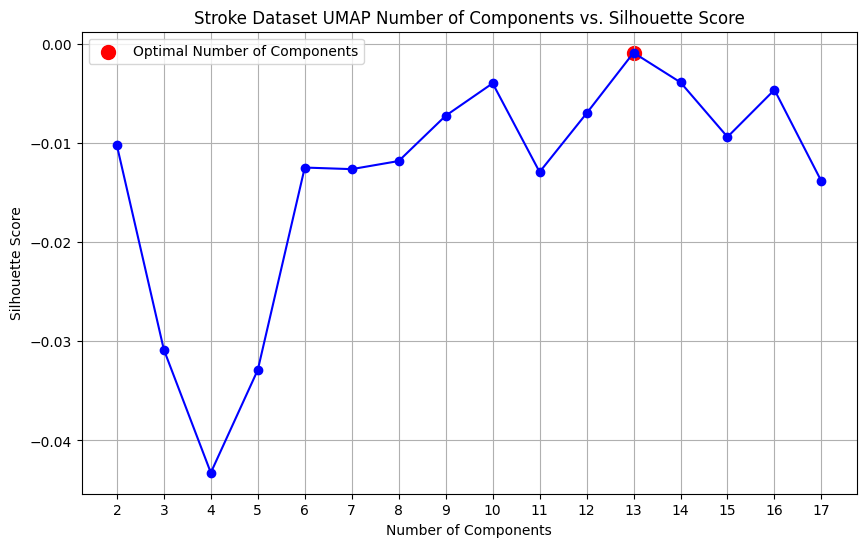

In [3]:
if __name__ == "__main__":
    # Set the range for the number of components
    n_components_range = list(range(2, strokeX.shape[1] - 1))[::-1]

    # Perform the UMAP experiment
    stroke_umap_results, stroke_best_config = umap_experiment(
        strokeX,
        strokeY,
        n_components_range,
        param_grid,
        n_splits=3,
        random_state=RANDOM_STATE,
    )

    # Print results
    display(stroke_umap_results)

    print(stroke_best_config)

    # Save the figures
    plot_umap_results(
        stroke_umap_results,
        "Stroke Dataset UMAP Number of Components vs. Silhouette Score",
        save_path="stroke_umap.png",
    )

100%|██████████| 18/18 [09:19<00:00, 31.11s/it]


,n_components,silhouette_score
0,19,0.873420
1,18,0.876675
2,17,0.872861
3,16,0.875488
4,15,0.877214
5,14,0.869386
6,13,0.869195
7,12,0.866973
8,11,0.871667
9,10,0.874803


{19: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 19, 'n_neighbors': 50}, 18: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 18, 'n_neighbors': 50}, 17: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 17, 'n_neighbors': 50}, 16: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 16, 'n_neighbors': 50}, 15: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 15, 'n_neighbors': 50}, 14: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 14, 'n_neighbors': 50}, 13: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 13, 'n_neighbors': 50}, 12: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 12, 'n_neighbors': 50}, 11: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 11, 'n_neighbors': 50}, 10: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 10, 'n_neighbors': 50}, 9: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 9, 'n_neighbors': 50}, 8: {'metric': 'euclidean', 'min_dist': 0.0, 'n_components': 8, 'n_

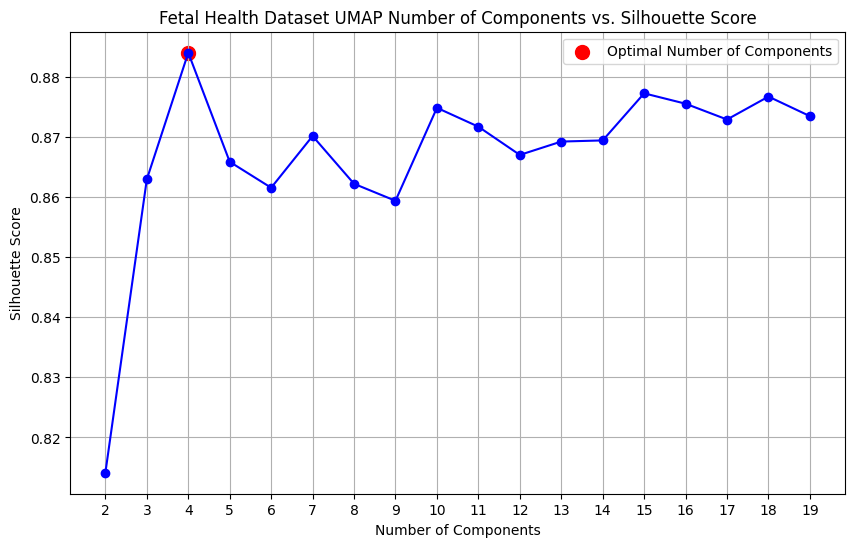

In [4]:
if __name__ == "__main__":
    # Set the range for the number of components
    n_components_range = list(range(2, fetalX.shape[1] - 1))[::-1]

    # Perform the UMAP experiment
    fetal_umap_results, fetal_best_config = umap_experiment(
        fetalX,
        fetalY,
        n_components_range,
        param_grid,
        n_splits=3,
        random_state=RANDOM_STATE,
    )

    # Print results
    display(fetal_umap_results)

    print(fetal_best_config)

    # Save the figures
    plot_umap_results(
        fetal_umap_results,
        "Fetal Health Dataset UMAP Number of Components vs. Silhouette Score",
        save_path="fetal_umap.png",
    )

# Generate cluster

In [5]:
if __name__ == "__main__":
    # stroke
    strokeX_test, strokeY_test = load_data(StrokeParams.data_test, StrokeParams.target_column)

    n_clusters = 13
    stroke_umap = umap.UMAP(random_state=RANDOM_STATE, **stroke_best_config[n_clusters])

    stroke_umap.fit(strokeX)
    strokeX_reduced = stroke_umap.transform(strokeX)
    strokeX_test_reduced = stroke_umap.transform(strokeX_test)

    strokeX_reduced = pd.DataFrame(
        strokeX_reduced, columns=[f"UMAP_{i}" for i in range(strokeX_reduced.shape[1])]
    )
    strokeX_reduced = pd.merge(strokeX_reduced, strokeY, left_index=True, right_index=True)
    strokeX_reduced.to_csv(f"strokeX_umap_{n_clusters}.csv", index=False)

    strokeX_test_reduced = pd.DataFrame(
        strokeX_test_reduced,
        columns=[f"UMAP_{i}" for i in range(strokeX_test_reduced.shape[1])],
    )
    strokeX_test_reduced = pd.merge(
        strokeX_test_reduced, strokeY_test, left_index=True, right_index=True
    )
    strokeX_test_reduced.to_csv(f"strokeX_test_umap_{n_clusters}.csv", index=False)

In [6]:
if __name__ == "__main__":
    # fetal health
    fetalX_test, fetalY_test = load_data(FetalHealthParams.data_test, FetalHealthParams.target_column)

    n_clusters = 4
    fetal_umap = umap.UMAP(random_state=RANDOM_STATE, **fetal_best_config[n_clusters])

    fetal_umap.fit(fetalX)
    fetalX_reduced = fetal_umap.transform(fetalX)
    fetalX_test_reduced = fetal_umap.transform(fetalX_test)

    fetalX_reduced = pd.DataFrame(
        fetalX_reduced, columns=[f"UMAP_{i}" for i in range(fetalX_reduced.shape[1])]
    )
    fetalX_reduced = pd.merge(fetalX_reduced, fetalY, left_index=True, right_index=True)
    fetalX_reduced.to_csv(f"fetalX_umap_{n_clusters}.csv", index=False)

    fetalX_test_reduced = pd.DataFrame(
        fetalX_test_reduced,
        columns=[f"UMAP_{i}" for i in range(fetalX_test_reduced.shape[1])],
    )
    fetalX_test_reduced = pd.merge(
        fetalX_test_reduced, fetalY_test, left_index=True, right_index=True
    )
    fetalX_test_reduced.to_csv(f"fetalX_test_umap_{n_clusters}.csv", index=False)